<a href="https://colab.research.google.com/github/zerweck/dscommunity-hackathon/blob/hackathon1/hackathon_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Setup Environment

In [ ]:
!git clone --branch hackathon1 https://github.com/zerweck/dscommunity-hackathon
%cd dscommunity-hackathon

In [ ]:
!pip install -r requirements.txt

In [25]:
import matplotlib.pyplot as plt

# Optional: Only if you want zoomable plots
!pip install mpld3
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

## Download Data

In [ ]:
from script_download_data import *
import expt_settings.configs

expt_name = 'electricity' # ['volatility', 'traffic', 'favorita']
folder = 'out'
# init data read
main(expt_name, True, folder)

## Format Data

In [11]:
from data_formatters.electricity import ElectricityFormatter
from data_formatters.base import DataTypes, InputTypes
class CustomElectricityFormatter(ElectricityFormatter):
  """Defines and formats data for the electricity dataset. Modified for extra features support 

  Note that per-entity z-score normalization is used here, and is implemented
  across functions.
  """
  _column_definition = [
      ('id', DataTypes.REAL_VALUED, InputTypes.ID),
      ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
      ('power_usage', DataTypes.REAL_VALUED, InputTypes.TARGET),
      ('power_usage_lag24', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('power_usage_lag48', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('power_usage_lag72', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('power_usage_lag168', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
  ]
def build_lags(data, col='power_usage', id_col='id', lags=[24, 48, 72, 168]):
    for i in lags:
      col_lag = "{}_lag{}".format(col, i)
      data[col_lag] = data.groupby(id_col)[col].shift(i)
    return data


In [12]:
# make experiment config
ExperimentConfig = expt_settings.configs.ExperimentConfig
config = ExperimentConfig(expt_name, folder)

#prepare data formatter 
data_formatter = config.make_data_formatter()
data_csv_path = config.data_csv_path

print("Loading & splitting data...")
data = pd.read_csv(data_csv_path, index_col=0)
data_w_lags = build_lags(data.copy())

# Pre-given Data Split
train, valid, test = data_formatter.split_data(data_w_lags.dropna())

Loading & splitting data...


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


## Describe Data

### Preprocessed Data

In [ ]:
train

power_usage        t  days_from_start  categorical_id  \
17712       -0.283480  26472.0             1103               0   
17713       -0.283480  26473.0             1103               0   
17714       -0.132741  26474.0             1103               0   
17715       -0.283480  26475.0             1103               0   
17716       -0.208111  26476.0             1103               0   
...               ...      ...              ...             ...   
10460738     0.277985  31555.0             1314             368   
10460739     0.069930  31556.0             1314             368   
10460740    -0.342464  31557.0             1314             368   
10460741    -0.030382  31558.0             1314             368   
10460742    -0.777150  31559.0             1314             368   

                         date      id      hour  day  day_of_week  month  \
17712     2014-01-08 00:00:00  MT_001 -1.661325    8    -0.499710      1   
17713     2014-01-08 01:00:00  MT_001 -1.516862    8    -0.499710      1   
17714     2014-01-08 02:00:00  MT_001 -1.372399    8    -0.499710      1   
17715     2014-01-08 03:00:00  MT_001 -1.227936    8    -0.499710      1   
17716     2014-01-08 04:00:00  MT_001 -1.083473    8    -0.499710      1   
...                       ...     ...       ...  ...          ...    ...   
10460738  2014-08-07 19:00:00  MT_370  1.083473    7     0.002368      8   
10460739  2014-08-07 20:00:00  MT_370  1.227936    7     0.002368      8   
10460740  2014-08-07 21:00:00  MT_370  1.372399    7     0.002368      8   
10460741  2014-08-07 22:00:00  MT_370  1.516862    7     0.002368      8   
10460742  2014-08-07 23:00:00  MT_370  1.661325    7     0.002368      8   

          hours_from_start  categorical_day_of_week  categorical_hour  \
17712            -1.731710                        2                 0   
17713            -1.731030                        2                 1   
17714            -1.730349                        2                 2   
17715            -1.729668                        2                 3   
17716            -1.728987                        2                 4   
...                    ...                      ...               ...   
10460738          1.728987                        3                19   
10460739          1.729668                        3                20   
10460740          1.730349                        3                21   
10460741          1.731030                        3                22   
10460742          1.731710                        3                23   

          power_usage_lag24  power_usage_lag48  power_usage_lag72  \
17712              1.586294           2.855330           2.538071   
17713              2.220812           3.172589           2.855330   
17714              1.903553           2.855330           2.855330   
17715              1.903553           2.855330           2.855330   
17716              1.903553           2.855330           2.855330   
...                     ...                ...                ...   
10460738       19202.702703       24783.783784       25067.567568   
10460739       21581.081081       24405.405405       25067.567568   
10460740       20256.756757       24027.027027       22972.972973   
10460741       19459.459459       20108.108108       22405.405405   
10460742       20418.918919       24162.162162       22162.162162   

          power_usage_lag168  
17712               2.538071  
17713               2.855330  
17714               2.855330  
17715               2.855330  
17716               2.538071  
...                      ...  
10460738        25837.837838  
10460739        24864.864865  
10460740        25729.729730  
10460741        22378.378378  
10460742        21932.432432  

[1861544 rows x 17 columns]

In [ ]:
train.groupby('id').size()

id
MT_001    5088
MT_002    5088
MT_003    5088
MT_004    5088
MT_005    5088
          ... 
MT_366    5088
MT_367    5088
MT_368    5088
MT_369    5088
MT_370    5088
Length: 369, dtype: int64

### Plot Data

power_usage    1.284026e-15
dtype: float64

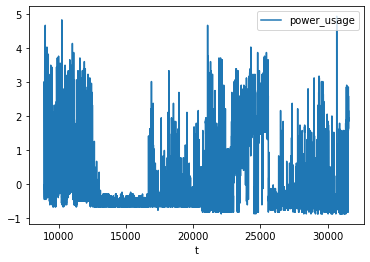

In [26]:
train.loc[train.id =='MT_001', ['t', 'power_usage']].plot(x = 't', y = 'power_usage')
train.loc[train.id =='MT_001', ['power_usage']].mean()

# Baseline Modeling 1: LightGBM

## Setup LGBM

In [13]:
import lightgbm as lgb

# Hardcode feature names
FEATURE_NAMES = ['categorical_id', 'hours_from_start', 'categorical_day_of_week', 'categorical_hour',
                               'power_usage_lag24', 'power_usage_lag48', 'power_usage_lag72', 'power_usage_lag168']
CAT_NAMES = ['categorical_id', 'categorical_day_of_week', 'categorical_hour']

# construct lgb datasets
train_data = lgb.Dataset(train[FEATURE_NAMES], 
                         label=train[['power_usage']], 
                         feature_name=FEATURE_NAMES, 
                         categorical_feature=CAT_NAMES)

val_data = lgb.Dataset(valid[FEATURE_NAMES], 
                       label=valid[['power_usage']], 
                         feature_name=FEATURE_NAMES, 
                         categorical_feature=CAT_NAMES)

valid[FEATURE_NAMES].dtypes


## Define hyperparameters

In [ ]:
num_round = 2000
param = {'num_leaves': 31, 'objective': 'regression', "learning_rate":0.01, "num_threads":6}

## Train Model

In [ ]:
fit = lgb.train(param, train_data, num_round, valid_sets=[val_data])

In [30]:
# Optional: Dump / Load pre-trained model
# fit.save_model('out/saved_models/electricity/lgbm_trained.booster')
# fit = lgb.Booster(model_file='out/saved_models/electricity/lgbm_trained.booster')

## Predict Testset

In [16]:
preds = fit.predict(test[FEATURE_NAMES])
preds

array([1.35772788, 1.31913633, 1.25190114, ..., 0.70336891, 0.53599288,
       0.56800293])

### Test Set Prediction Results

In [19]:
np.sqrt(np.mean((test.power_usage - preds)**2))

0.479682399857009

### Plot Predictions

In [23]:
# some plots
nrow = 4

fig, ax = plt.subplots(2, nrow, figsize=(12,8), facecolor='w', edgecolor='k')
ids = np.unique(test.id)[:8]
for i in range(8):
    ax[i//nrow,i%nrow].plot(test.loc[test.id == ids[i], 't'], test.loc[test.id == ids[i], 'power_usage'])
    ax[i//nrow,i%nrow].plot(test.loc[test.id == ids[i], 't'], preds[test.id == ids[i]])
    ax[i//nrow,i%nrow].set_title(ids[i])


#plt.plot(test.t, preds)


### Feature Importance
Default Importance metric: Splits = How often was this Feature used in a split in all trees

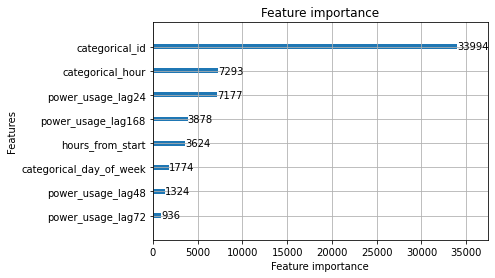

In [18]:
lgb.plot_importance(fit)